# Scalability of distributed machine learning

## Models of computation and communication
Lets consider bulk synchronous parallel processing model. Time of one iteration consists of computation and communication times that depend on the number of operations C, data D and number of nodes n.
<code>
  *T = t<sub>cp</sub> + t<sub>cm</sub>*
  *t<sub>cp</sub>(n,C) = Cf(n)*
  *t<sub>cm</sub>(n,D) = Dg(n)*
</code>  
  
In the most simple case, <code>f(n)</code> depends on the number of nodes inversely, i.e.
<code> 
  *t<sub>cp</sub> = C/n*
</code>
This case can be attributed to as "data parallelism". We will consider "model parallelism" further.

Communication can be all-to-all, i.e. each node needs an update from every other node:
<code> 
  *t<sub>cm</sub> = Dn*
</code>
In some cases it can be all-reduce or tree-aggregation:
<code> 
  *t<sub>cm</sub> = Dlog(n)*
</code>


In [1]:
import math
def t_cp(n, c):
    return c / n
def t_cm(n, d):
    return d * math.log (n, 2)
def t_cmlin(n, d):
    return d * n
def t_total(n, c, d):
    return t_cp(n, c) + t_cm(n, d)
def t_lin(n, c, d):
    return t_cp(n, c) + t_cmlin(n, d)

Lets plot graphs to see how the total time behave depending on the number of nodes:

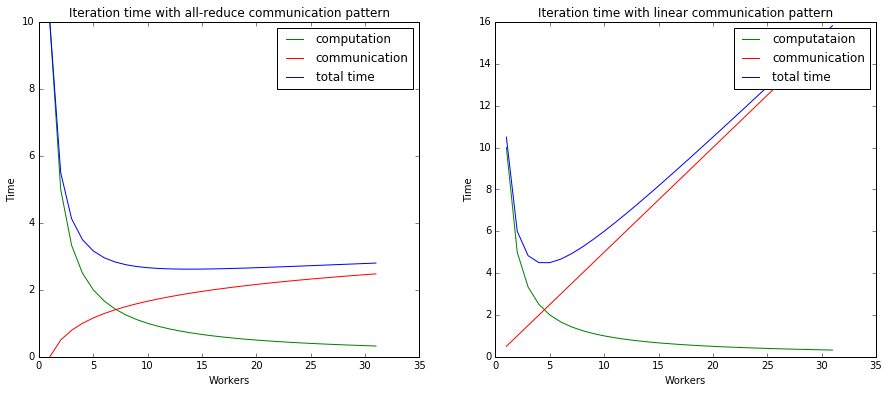

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
n = np.arange(1, 32)
c = 10
d = 0.5
tcpData = np.vectorize(t_cp)(n, c)
tcmData = np.vectorize(t_cm)(n, d)
tData = np.vectorize(t_total)(n, c, d)
tcmlinData = np.vectorize(t_cmlin)(n, d)
tlinData = np.vectorize(t_lin)(n, c, d)
plt.figure(1, figsize=(15, 6))
plt.subplot(121)
leg1, = plt.plot(n,tcpData, color="green", label='computation')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time with all-reduce communication pattern")
plt.legend(handles=[leg1, leg2, leg3])
plt.subplot(122)
leg1, = plt.plot(n, tcpData, color="green", label='computataion')
leg2, = plt.plot(n, tcmlinData, color="red", label='communication')
leg3, = plt.plot(n, tlinData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time with linear communication pattern")
plt.legend(handles=[leg1, leg2, leg3])

One can see that:
  - There is an optimal number of nodes that provides the minimal total time.
  - Total time for all-reduce communication pattern has smooth shape, i.e. one can use less than optimal nodes and still get near to minimal time
  - All-reduce communication has better scalability than all-to-all

Lest study these models on examples of various machine learning algorithms.

## Scalability of distributed deep learning
### Scalability of gradient descent
Lets consider data parallel distributed gradient descent. 
<code>
  *t<sub>cp</sub>(n,c,p) = c/(np)*
</code>
where *`n`* is number of nodes, *`p`* is the computational power of the node, *`c`* is number of floating point operations.
<code>
  *t<sub>cm</sub>(n,w,b) = 2(w/b)log(n)*
</code>
where *`n`* is number of nodes, *`b`* is bandwidth, *`w`* is the size of the weights in bits.

In [23]:
import math
def tcp(n, flops, p):
    return flops / (n * p)
def tcm(n, weights, b):
    return 2 * (32 * weights / b) * math.log (n, 2)
def t(n, weights, flops, b, p):
    return tcp(n, flops, p) + tcm(n, weights, b)

### Estimation for published models
Lets consider the published models. 
  - Logistic regression
      - Click trough rate (CTR) prediction 16M weights, 125 non-zero features [6]
  - Fully connected
      - MSFT speech: 45.1M weights [3]
  - Convolutional 
      - AlexNet, convolutional neural network, 60M weights, 832M MULT-ADD operations for inference [1]
      - Inception v3, cnn, 25M weights, 5B MULT-ADD operations for inference [2]
  - Recurrent
      - DeepSpeech [tbd]

Hardware and other settings:
  - 16 GB/s PCI-express or Infiniband interconnect
  - 4TFlops nVidia GPU
  - 1024 mini batch size (divided by the number of nodes)

TODO: consider the speedup for graphs

### Logistic regression

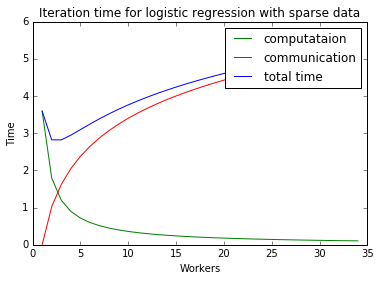

In [36]:
#Criteo & MS
weights = 16E6
batch = 2.3E9 # Batch LBFGS
nonZero = 125 # 125 non-zero features
#  
flops = 2 * nonZero * batch
# Network 1Gb/s (peak can be 100%)
b = 1E9
# Standard CPU 200 GFlops (peak is 80%)
p = 0.8 * 200E9
n = np.arange(1, 35)
#vtcp = np.vectorize(tcp)
#vtcm = np.vectorize(tcm)
#vt = np.vectorize(t)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for logistic regression with sparse data")
plt.legend(handles=[leg1, leg2, leg3])

### Fully connected

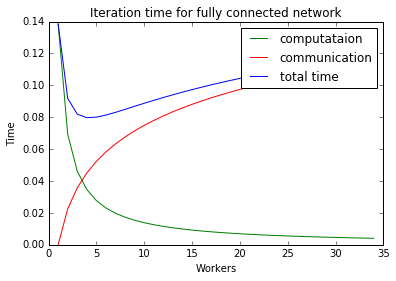

In [27]:
#MSFT
weights = 45.1E6
batch = 1024 #SGD
# weights = MULT-ADD operations, 3x for training, 2x for FLOPS
flops = 2 * weights * 3 * batch
# PCI express v3 16GB/s (peak can be 100%)
b = 8 * 16E9
# nVidia 4 TFlops (peak is 50%)
p = 0.5 * 4E12
n = np.arange(1, 35)
#vtcp = np.vectorize(tcp)
#vtcm = np.vectorize(tcm)
#vt = np.vectorize(t)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for fully connected network")
plt.legend(handles=[leg1, leg2, leg3])

In [39]:
print("Speedup 1 node vs 4:", t(1, weights, flops, b, p) / t(4,  weights, flops, b, p))
print("Speedup 4 nodes vs 25:", t(4, weights, flops, b, p) / t(25,  weights, flops, b, p))

Speedup 1 node vs 4: 1.2196932736567465
Speedup 4 nodes vs 25: 0.6014293066028429


### Spark ANN benchmark

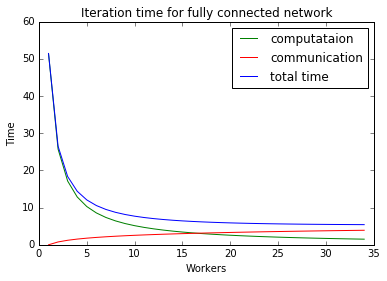

In [40]:
#MSFT
weights = 12E6
batch = 60000 #MNIST
# weights = MULT-ADD operations, 3x for training, 2x for FLOPS
flops = 2 * weights * 3 * batch
# 1 Gbit network (peak can be 100%)
b = 1E9
# nVidia 4 TFlops (peak is 80%)
p = 0.8 * 105E9
n = np.arange(1, 35)
#vtcp = np.vectorize(tcp)
#vtcm = np.vectorize(tcm)
#vt = np.vectorize(t)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for fully connected network")
plt.legend(handles=[leg1, leg2, leg3])

In [42]:
print("Speedup 1 node vs 5:", t(1, weights, flops, b, p) / t(5,  weights, flops, b, p))
print("Speedup 5 nodes vs 13:", t(5, weights, flops, b, p) / t(13,  weights, flops, b, p))

Speedup 1 node vs 5: 4.261228181053837
Speedup 5 nodes vs 13: 1.7753732897449417


### Convolutional networks

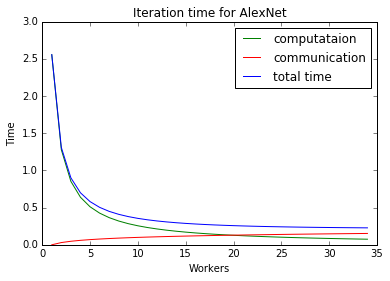

In [29]:
#Google AlexNet 32 bit weights
weights = 60E6
# MULT-ADD ops, 2x for FLOPS, 3x for training
flops = 2 * 832E6 * 3 * 1024
# PCI express v3 16GB/s (peak can be 100%)
#vtcp = np.vectorize(tcp)
#vtcm = np.vectorize(tcm)
#vt = np.vectorize(t)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for AlexNet")
plt.legend(handles=[leg1, leg2, leg3])

Speedups:

In [30]:
print("Speedup 1 node vs 25:", t(1, weights, flops, b, p) / t(25,  weights, flops, b, p))
print("Speedup 25 nodes vs 100:", t(25, weights, flops, b, p) / t(100,  weights, flops, b, p))

Speedup 1 node vs 25: 10.581181827299572
Speedup 25 nodes vs 100: 1.0741618247608213


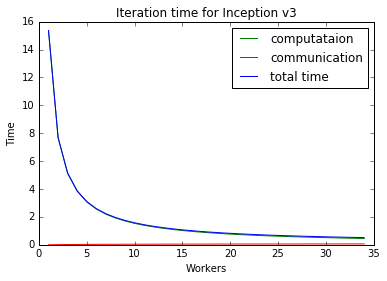

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#Google Inception v3
weights = 25E6
flops = 2 * 5E9 * 3 * 1024
# PCI express v3 16GB/s (peak can be 100%)
#vtcp = np.vectorize(tcp)
#vtcm = np.vectorize(tcm)
#vt = np.vectorize(t)
tcpData = np.vectorize(tcp)(n, flops, p)
tcmData = np.vectorize(tcm)(n, weights, b)
tData = np.vectorize(t)(n, weights, flops, b, p)
leg1, = plt.plot(n,tcpData, color="green", label='computataion')
leg2, = plt.plot(n,tcmData, color="red", label='communication')
leg3, = plt.plot(n, tData, color="blue", label='total time')
plt.ylabel("Time")
plt.xlabel("Workers")
plt.title("Iteration time for Inception v3")
plt.legend(handles=[leg1, leg2, leg3])

Speedups:

In [32]:
print("Speedup 1 node vs 25:", t(1, weights, flops, b, p) / t(25,  weights, flops, b, p))
print("Speedup 50 nodes vs 25:", t(25, weights, flops, b, p) / t(50,  weights, flops, b, p))
print("Speedup 100 nodes vs 25:", t(25, weights, flops, b, p) / t(100,  weights, flops, b, p))
print("Speedup 200 nodes vs 25:", t(25, weights, flops, b, p) / t(200,  weights, flops, b, p))

Speedup 1 node vs 25: 22.8419080396301
Speedup 50 nodes vs 25: 1.7801493114972944
Speedup 100 nodes vs 25: 2.8415521251862446
Speedup 200 nodes vs 25: 3.9016838766907442


Interestingly, we get speedups similar to empyrical results reported in [5]:
  - 25 relative to 1: 25
  - 100 relative to 25: 3.56
  - 200 relative to 25: 8.06

## Appendix
### Weights and Flops estimation
The following formulas give estimations of number of weights and operations for training fully-connected and convolutional neural networks. Training consists of the forward propagation, backpropagation of error and gradient computation. Lest consider fully-connected networks:
  - Weights: intputs times outputs for each layer plus bias: w = Sum(mn+n)
  - Training 
    - Forward: vector-matrix multiplication for each layer, bias addition and activation function, ~2mn=2w
    - Backward: vector-matrix and elementwise vector multiplications, ~2nm = 2w
    - Gradient computation: column-vector row-vector products, ~nm = w
    - Gradient update and total: 5w + 1w = 6w
    - Counting "multiply-add" operations: 3w

In [11]:
def weightsAndFlops(layers):
    w = 0
    for i in range(1, len(layers)):
        w = w + layers[i - 1] * layers[i] + layers[i]
    return (w, 3 * w)
assert(weightsAndFlops([784, 10])[0] == 7850)
# MSFT model [3]
assert(round(weightsAndFlops([39 * 11, 2048, 2048, 2048, 2048, 2048, 2048, 2048, 9304])[0] / 1E5, 0) * 1E5 == 45.1E6)

Convolutional neural networks:
  - Weights: (feature maps size plus bias) times depth and number of maps
  - Training
     - Forward: dot product of input and weights, summation of the result and bias addition, for each feature map and output neuron
     - Backward: similar
     - Gradient computation: similar
     - Total in "multiply-add" operations: 3w
     
Bias adds a lot more weights to convolutional networks, so in recent papers it is not used given that data is normalized.

In [12]:
import numpy as np
def computeConvOutput(data, layer):
    n = layer['count']
    k = layer['size']
    b = layer['border']
    s = layer['stride']
    c = (data[0] - k + b) // s + 1   
    return [c, c, n]
def computePoolOutput(data, layer):
    n = data[2]
    k = layer['size']
    b = layer['border']
    s = layer['stride']
    c = (data[0] - k + b) // s + 1   
    return [c, c, n]
def cnnWeightsAndFlops(inputLayer, layers, useBias):
    w = 0.0
    f = 0.0
    inputData = inputLayer
    for i in range(0, len(layers)):
        layer = layers[i]
        if (layer['type'] == 'conv'):
            n = layer['count']
            k = layer['size']
            d = layer['depth']
            inputData = computeConvOutput(inputData, layer)
            c = inputData[0]
            bw = 0
            if (useBias): 
                bw = c * c
            w = w + n * (k * k * d + bw)
            f = f + n * (k * k * d * c * c)
        if (layer['type'] == 'pool'):
            n = inputData[2]
            inputData = computePoolOutput(inputData, layer)
        if (layer['type'] == 'full'):
            k = layer['size']
            inputFlat = np.product(inputData)
            bw = 0
            if (useBias):
                bw = k
            w = w + k * inputFlat + bw
            f = f + k * inputFlat
            inputData = [k]
    return (w, 3 * f)

Unit test

In [13]:
# LeCun et al. 1982 (1068 + 2592 + 5790 + 310 == 9760 weights)
assert cnnWeightsAndFlops([16, 16, 1], [{'type' : 'conv', 'count' : 12, 'size' : 5, 'depth' : 1, 'stride': 2, 'border' : 3}], True)[0] == 1068
assert cnnWeightsAndFlops([16, 16, 1], [{'type' : 'conv', 'count' : 12, 'size' : 5, 'depth' : 1, 'stride': 2, 'border' : 3},
                         {'type' : 'conv', 'count' : 12, 'size' : 5, 'depth' : 8, 'stride': 2, 'border' : 3},
                         {'type' : 'full', 'size' : 30},
                         {'type' : 'full', 'size' : 10}], True)[0] == 9760
# Krizhevsky et al. 2012, AlexNet, see also https://github.com/BVLC/caffe/blob/master/models/bvlc_alexnet/deploy.prototxt
assert(computeConvOutput([227, 227, 3], {'type' : 'conv', 'count' : 96, 'size' : 11, 'depth' : 3, 'stride': 4, 'border' : 0}) == [55, 55, 96])
assert(computePoolOutput([55, 55, 96], {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}) == [27, 27, 96])
assert(computeConvOutput([27, 27, 256], {'type' : 'conv', 'count' : 256, 'size' : 5, 'depth' : 48, 'stride': 1, 'border' : 4}) == [27, 27, 256])
assert(computePoolOutput([27, 27, 256], {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}) == [13, 13, 256])
assert(computeConvOutput([13, 13, 256], {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 256, 'stride': 1, 'border' : 2}) == [13, 13, 384])
assert(computeConvOutput([13, 13, 384], {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 192, 'stride': 1, 'border' : 2}) == [13, 13, 384])
assert(computeConvOutput([13, 13, 256], {'type' : 'conv', 'count' : 256, 'size' : 3, 'depth' : 192, 'stride': 1, 'border' : 2}) == [13, 13, 256])
assert(computePoolOutput([13, 13, 256], {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}) == [6, 6, 256])
#example AlexNet from http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf
alexWeights, alexFlops = cnnWeightsAndFlops([227, 227, 3], [
                           {'type' : 'conv', 'count' : 96, 'size' : 11, 'depth' : 3, 'stride': 4, 'border' : 0},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0},
                           {'type' : 'conv', 'count' : 256, 'size' : 5, 'depth' : 48, 'stride': 1, 'border' : 4},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0},
                           {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 256, 'stride': 1, 'border' : 2},
                           {'type' : 'conv', 'count' : 384, 'size' : 3, 'depth' : 384, 'stride': 1, 'border' : 2}, # depth is 192 in paper
                           {'type' : 'conv', 'count' : 256, 'size' : 3, 'depth' : 192, 'stride': 1, 'border' : 2},
                           {'type' : 'pool', 'size' : 3, 'stride': 2, 'border' : 0}, 
                           {'type' : 'full', 'size' : 4096},
                           {'type' : 'full', 'size' : 4096},
                           {'type' : 'full', 'size' : 1000}
                          ], False)
# weights ~ 60M, forward pass ~ 832M Flops
assert(round(alexWeights / 1E7) * 1E7 == 60E6)
assert(round(alexFlops / 3E8) * 1E8 == 8E8)


## References
  1. Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012. (slides: http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf)
  2. Szegedy, Christian, et al. "Rethinking the Inception Architecture for Computer Vision." arXiv preprint arXiv:1512.00567 (2015).
  3. Seide, Frank, Gang Li, and Dong Yu. "Conversational Speech Transcription Using Context-Dependent Deep Neural Networks." Interspeech. 2011.
  4. Iandola, Forrest N., et al. "FireCaffe: near-linear acceleration of deep neural network training on compute clusters." arXiv preprint arXiv:1511.00175 (2015).
  5. Chen, Jianmin, et al. "Revisiting Distributed Synchronous SGD." arXiv preprint arXiv:1604.00981 (2016).
  6. Chapelle, Olivier, Eren Manavoglu, and Romer Rosales. "Simple and scalable response prediction for display advertising." ACM Transactions on Intelligent Systems and Technology (TIST) 5.4 (2015): 61.
  